## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. 

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

In [4]:
!pip install pandas numpy matplotlib scikit-learn


import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


### Q1. 

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [5]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. 

What do you notice about the frequency of occurrence of different tokens? How does it look?

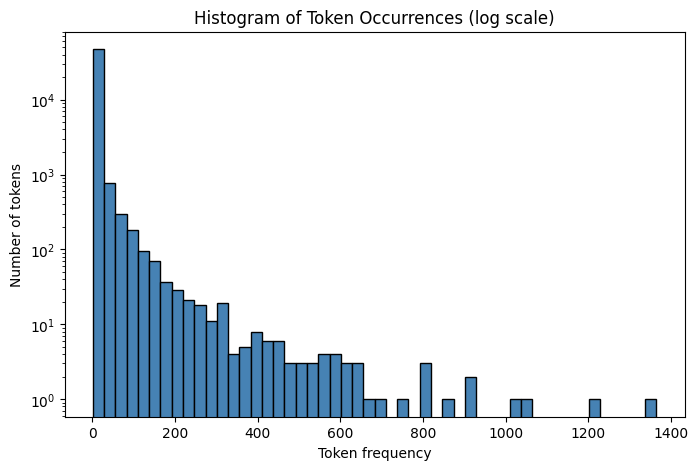

In [6]:
# Convert to DataFrame for easier plotting
tokens_df = pd.DataFrame(token_freq, columns=["token", "count"])

plt.figure(figsize=(8,5))
plt.hist(tokens_df["count"], bins=50, log=True, color="steelblue", edgecolor="black")
plt.title("Histogram of Token Occurrences (log scale)")
plt.xlabel("Token frequency")
plt.ylabel("Number of tokens")
plt.show()

1. Looking at the histogram, we can see that it is extremely right-skewed. A few few number of tokens appear thousands of times, while most tokens occur rarely. So, as token frequency increases on the histogram, the number of tokens decreases exponentially.

### Q2. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [13]:
!pip install fastparquet


  Using cached fastparquet-2024.11.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.2 kB)
  Using cached cramjam-2.11.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
Using cached fastparquet-2024.11.0-cp313-cp313-macosx_11_0_arm64.whl (683 kB)
Using cached cramjam-2.11.0-cp313-cp313-macosx_11_0_arm64.whl (1.7 MB)
Using cached fsspec-2025.9.0-py3-none-any.whl (199 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [14]:
df = pd.read_parquet('/Users/calebkim7/pca_assignment/data/Phishing_clean.parquet')
print(df.shape)
df.head()

# Separate outcome and predictors
y = df["Email Type"]
X = df.drop(columns=["Email Type"])

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predictions and R²
y_pred_train = lm.predict(X_train)
y_pred_test  = lm.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)

print(f"R² on Training set: {r2_train:.4f}")
print(f"R² on Test set:     {r2_test:.4f}")

# Examine coefficients
coef_df = pd.DataFrame({
    "token": X.columns,
    "coef": lm.coef_
}).sort_values(by="coef", ascending=False)

print("\nTop 10 positive tokens:")
print(coef_df.head(10))

print("\nTop 10 negative tokens:")
print(coef_df.tail(10))

(18634, 2712)
R² on Training set: 0.7670
R² on Test set:     0.6659

Top 10 positive tokens:
                  token      coef
740           localized  0.824350
2362            thermal  0.747006
851             crawler  0.696167
1406         helvetica,  0.598560
906               aging  0.594956
1839              form.  0.576886
1552           a:active  0.574480
1245  {text-decoration:  0.497075
2532             xanaax  0.491981
2566         transcript  0.488978

Top 10 negative tokens:
                  token      coef
818                cnet -0.453777
1145             issue: -0.465547
1256             arial, -0.482141
2559            april's -0.486483
2639            shopper -0.486678
2657              zdnet -0.560954
1494         retrieving -0.573761
2242              gray; -0.574480
1504  background-image: -0.622909
835        intervention -1.259257


2. Positive coefficients increase the probability of a phishing scam, while negative coefficients increase the probability of a legitimate email. I've outputted some of the most positive and negative tokens above showing the words that most strongly influence predictions

### Q3. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

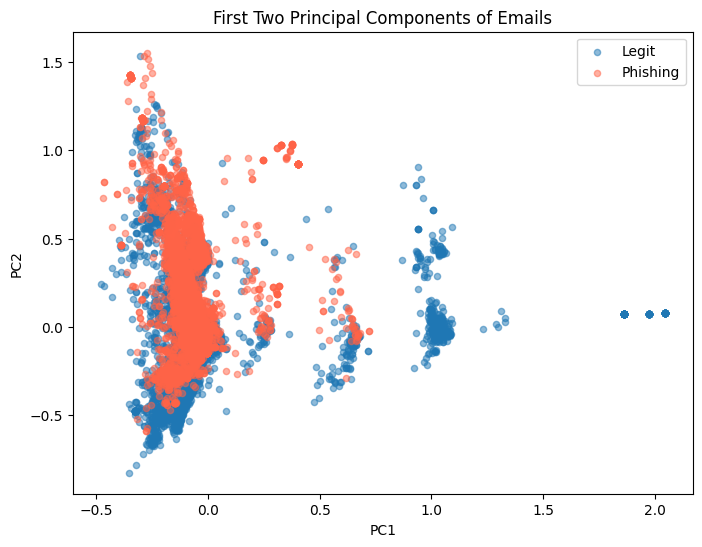

In [15]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X)

pca_df = pd.DataFrame(X_pca_2, columns=["PC1", "PC2"])
pca_df["Email Type"] = y.values

plt.figure(figsize=(8,6))
plt.scatter(
    pca_df.loc[pca_df["Email Type"]==0, "PC1"],
    pca_df.loc[pca_df["Email Type"]==0, "PC2"],
    alpha=0.5, label="Legit", s=20
)
plt.scatter(
    pca_df.loc[pca_df["Email Type"]==1, "PC1"],
    pca_df.loc[pca_df["Email Type"]==1, "PC2"],
    alpha=0.5, label="Phishing", s=20, color="tomato"
)
plt.title("First Two Principal Components of Emails")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


3. Looking at plot, we can see that most phishing emails cluster in one main region. However, legit many emails also occupy that space. Overall, legit emails are more spread out while most phishing emails are close together.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [16]:
pca_full = PCA(n_components=2610, random_state=42)
X_train_pca = pca_full.fit_transform(X_train)
X_test_pca  = pca_full.transform(X_test)

lm_pca = LinearRegression()
lm_pca.fit(X_train_pca, y_train)

y_train_pred_pca = lm_pca.predict(X_train_pca)
y_test_pred_pca  = lm_pca.predict(X_test_pca)

r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca  = r2_score(y_test,  y_test_pred_pca)

print(f"PCA Regression R² (train): {r2_train_pca:.4f}")
print(f"PCA Regression R² (test):  {r2_test_pca:.4f}")

PCA Regression R² (train): 0.7662
PCA Regression R² (test):  0.6683


4. R^2 on the test and training sets are very similar for both. It shows that PCA gives a comparable predictive performace to linear regression.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components to run high-dimensional regression has many advantages. The original data in this example contains thousands of word features that are highly correlated and mostly sparse. This can cause issues like overfitting and unstable coefficient estimates. PCA transforms the correlated variables into a smaller number of uncorrelated components that capture most of the variance within the data. So, through regressing on these components instead of the raw words, we can reduce noise and reduncancy, improve computational efficiency, and even make the model more generalizable to unseen data. In conclusion, PCA allows the regression to focus on the key underlying patterns in the emails instead of being distracted by individual overlapping word features.